Wave length scale, nm: 1.07
sum F(λ): 1.0000000000000002


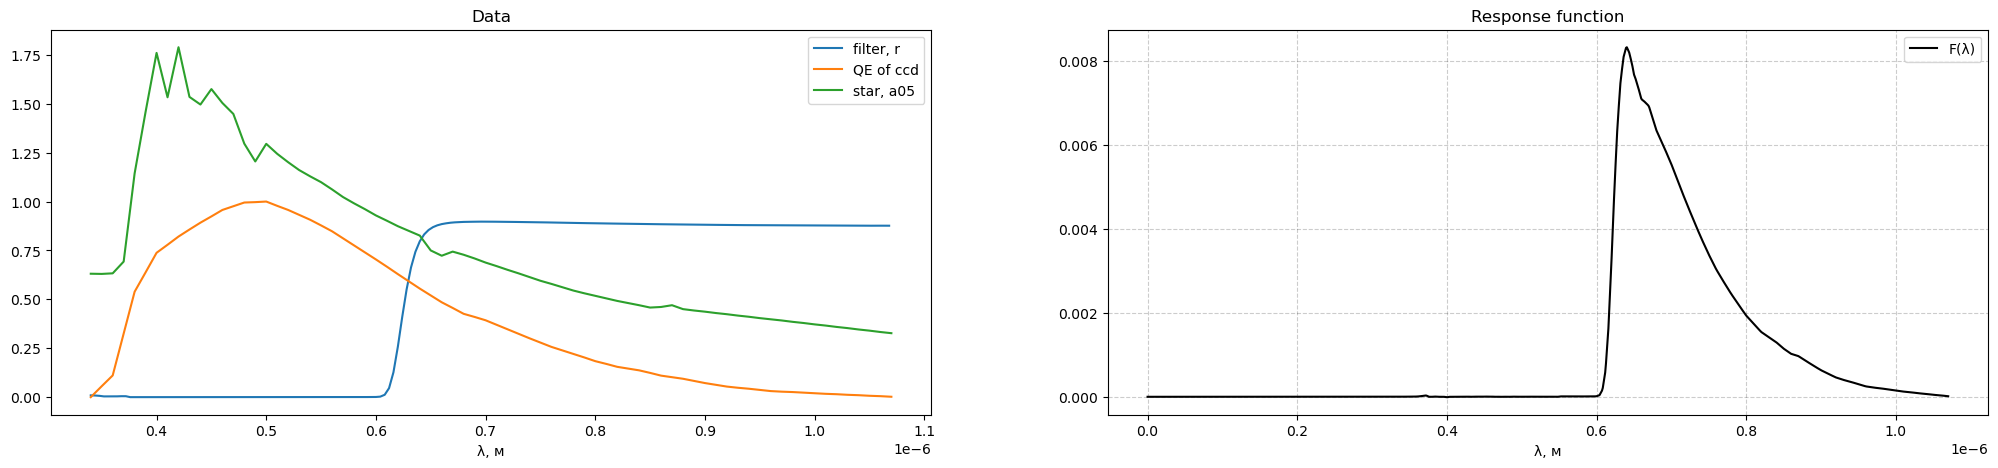

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.seterr(all="ignore")

# --------------------- Spectral Responce --------------------------
spectral_filter = pd.read_csv("KC19_d16t4_Safonov.csv", sep = ';')
spectral_filter['14.42.43'] = spectral_filter['14.42.43'] / 100

ccd_QE = pd.read_csv("ccd_prosilica2.crv", sep = ' ')
ccd_QE['X'] = ccd_QE['X'] * 1000

star = pd.read_csv("a05.sp", sep = ' ')

# на данном этапе мы обрезаем значения файлов так, чтобы они покрывались всеми тремя файлами
tmp_min = np.max([ccd_QE['X'][0], star['X'][0], spectral_filter['WAVE_LENGTH'][0]])
tmp_max = np.min([ccd_QE['X'].iat[-1], star['X'].iat[-1], spectral_filter['WAVE_LENGTH'].iat[-1]])

spectral_filter = spectral_filter[spectral_filter['WAVE_LENGTH'] < tmp_max]
X1 = spectral_filter['WAVE_LENGTH'] * pow(10, -9) # [м]
Y1 = spectral_filter['14.42.43']

ccd_QE = ccd_QE[ccd_QE['X'] > tmp_min]
X2 = ccd_QE['X'] * pow(10, -9) # [м]
Y2 = ccd_QE['Y']

star = star[star['X'] > tmp_min]
X3 = star['X'] * pow(10, -9) # [м]
Y3 = star['Y'] 

# т.к. разбивка по осям отличается, нужно свести их к одной, потому что далее мы будем перемножать значения, чтобы
# определить функцию спектрального отклика
coeff = 1
k = 1000*coeff
max_lambda = tmp_max*coeff
main_lambdas = np.linspace(0, max_lambda, k) * pow(10, -9) # [м]

interpolate_df = np.interp(main_lambdas, X1, Y1)
interpolate_ccd = np.interp(main_lambdas, X2, Y2)
interpolate_a05 = np.interp(main_lambdas, X3, Y3)
result = interpolate_df * interpolate_ccd * interpolate_a05

main_result = result/np.sum(result) # нормировка функции спектрального отклика

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))

ax1.plot(X1, Y1, label = 'filter, r')
ax1.plot(X2, Y2, label = 'QE of ccd')
ax1.plot(X3, Y3, label = 'star, a05')
ax1.legend()
ax1.set_title('Data')
ax1.set_xlabel('λ, м')

ax2.plot(main_lambdas, main_result, c='black', label='F(λ)')
ax2.set_xlabel('λ, м')
ax2.legend()
ax2.set_title('Response function')
ax2.grid(color = 'black', linestyle='--', alpha = 0.2)

print('Wave length scale, nm:', max_lambda/k)
print('sum F(λ):', np.sum(main_result))

max lambda: 107000.0 [нм]
шаг по длине волны: 1.07 [нм]
max omega: 934579439.2523364 [м^-1]
int F(λ): 0.9999999999999993


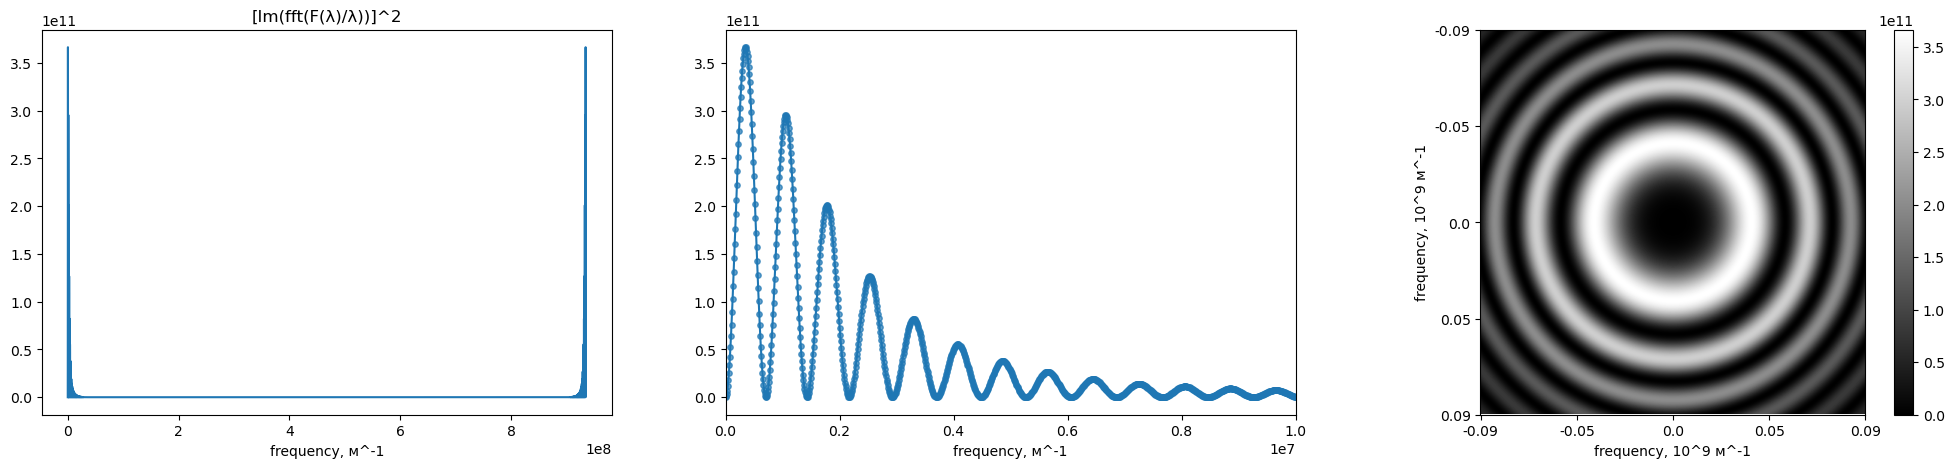

In [24]:
coeff = 100
k = 1000*coeff
max_lambda = tmp_max*coeff
print('max lambda:', max_lambda, '[нм]')
print('шаг по длине волны:', max_lambda/k, '[нм]')
lambdas = np.linspace(0, max_lambda, k) * pow(10, -9) # [м]

interpolate_df = np.interp(lambdas, X1, Y1)
interpolate_ccd = np.interp(lambdas, X2, Y2)
interpolate_a05 = np.interp(lambdas, X3, Y3)
result = interpolate_df * interpolate_ccd * interpolate_a05

result = result/np.sum(result) # нормировка функции спектрального отклика

delta_lambdas = (max_lambda / len(lambdas)) * pow(10, -9) # период дискредизации, шаг по частоте [м]
omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]
print('max omega:', omega_lambdas_scale, '[м^-1]')
res_fft = pow((np.imag(np.fft.fft(result/lambdas))), 2)

z = 2000 # дистанция распространения, [м]
nx = 512 # размер окна, [n_pix]
D = 2.5 # диаметр телескопа, [м]
D_pix = 228 # диаметр телескопа в пикселях, [n_pix]
delta = D/D_pix # шаг субапертуры, период дискретизации (то, насколько одно значение отстает от следующего) [м]
f_scale = 1/(delta*nx) # шаг по частоте, [м^-1]

xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
xx_scale = f_scale * xx 
yy_scale = f_scale * yy
f_abs = np.sqrt(pow(xx_scale, 2) + pow(yy_scale, 2))

omega = 0.5 * z * pow(f_abs, 2) # аргумент, шаг по частоте, [м^-1]
omega = np.ravel(omega)
omega_new = np.interp(omega, np.linspace(0, omega_lambdas_scale, k), res_fft)
omega_new = np.resize(omega_new, (nx, nx))


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

ax1.plot(np.linspace(0, omega_lambdas_scale, k), res_fft)
ax1.set_title('[Im(fft(F(λ)/λ))]^2')
ax1.set_xlabel('frequency, м^-1')

ax2.scatter(np.linspace(0, omega_lambdas_scale, k), res_fft, alpha=0.7, s=15)
ax2.plot(np.linspace(0, omega_lambdas_scale, k), res_fft)
ax2.set_xlim(xmax = 0.1*pow(10, 8))
ax2.set_xlim(xmin = 0*pow(10,8))
ax2.set_xlabel('frequency, м^-1')

fig.colorbar(ax3.imshow(omega_new, cmap='gray'), ax=ax3)
ax3.grid(False)
x = np.round(pow(10, -9) * omega_lambdas_scale/10 * np.linspace(-omega_new.shape[0]//2, omega_new.shape[0]//2, 5) / 256, 2)
ax3.set_xticks(np.linspace(0, omega_new.shape[1], 5))
ax3.set_yticks(np.linspace(0, omega_new.shape[0], 5))
ax3.set_xticklabels(x)
ax3.set_yticklabels(x)
ax3.set_xlabel('frequency, 10^9 м^-1')
ax3.set_ylabel('frequency, 10^9 м^-1')

print(' ')

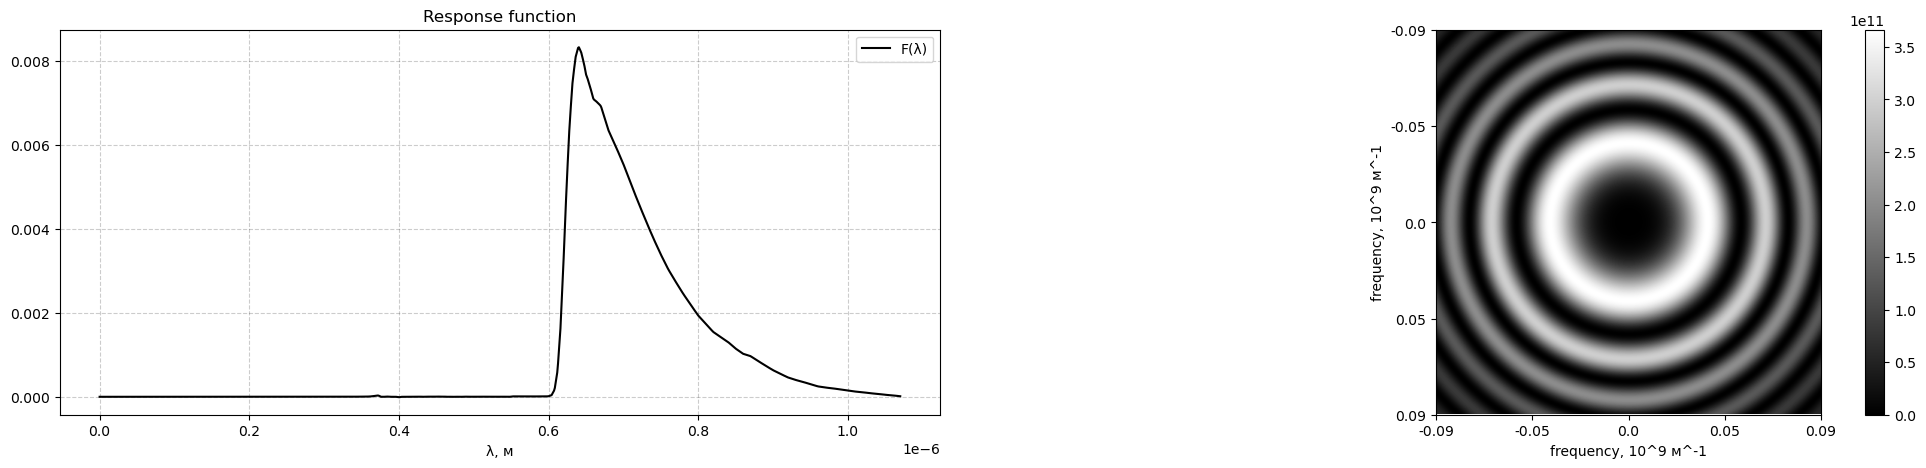

In [26]:
# fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(25, 5))

# ax1.plot(main_lambdas, main_result, c='black', label='F(λ)')
# ax1.set_xlabel('λ, м')
# ax1.legend()
# ax1.set_title('Response function')
# ax1.grid(color = 'black', linestyle='--', alpha = 0.2)

# fig.colorbar(ax3.imshow(omega_new, cmap='gray'), ax=ax3)
# ax3.grid(False)
# x = np.round(pow(10, -9) * omega_lambdas_scale/10 * np.linspace(-omega_new.shape[0]//2, omega_new.shape[0]//2, 5) / 256, 2)
# ax3.set_xticks(np.linspace(0, omega_new.shape[1], 5))
# ax3.set_yticks(np.linspace(0, omega_new.shape[0], 5))
# ax3.set_xticklabels(x)
# ax3.set_yticklabels(x)
# ax3.set_xlabel('frequency, 10^9 м^-1')
# ax3.set_ylabel('frequency, 10^9 м^-1')

# fig.savefig('C:/astro/Response_func2.png', bbox_inches='tight')
# print(' ')

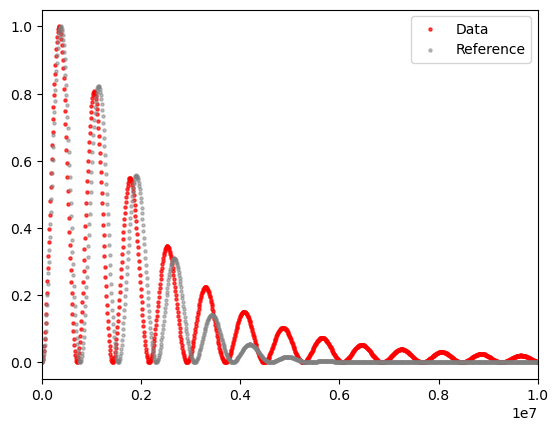

In [49]:
def reference_filter(coeff, lambda_=None, sigma=None):
    # eq. 18 - tokovinin2003
        # sigma: FWHM = 2*sqrt(2*Ln(2))*sigma, [м]
        # lambda_: длина волны, [м]

    k = 1000*coeff
    max_lambda = tmp_max*coeff

    lambdas = np.linspace(0, max_lambda, k) * pow(10, -9) # длина волны, [м]
    delta_lambdas = (max_lambda / len(lambdas)) * pow(10, -9) # период дискредизации, [м]
    omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]

    a1 = (lambdas / lambda_) * (1 / (sigma * np.sqrt(2 * np.pi)))
    a2 = np.exp( - pow(lambdas - lambda_, 2) / (2 * pow(sigma, 2)))
    F = a1 * a2
    F = F/np.sum(F) # нормировка для Фурье-преобразования
    F_fft = np.fft.fft(F)
    F_fft2 = pow((np.imag(np.fft.fft(F/lambdas))), 2)
    
    plt.figure()
    plt.scatter(np.linspace(0, omega_lambdas_scale, k), res_fft/np.max(res_fft), alpha=0.7, s=5, color='red', label='Data')
    plt.scatter(np.linspace(0, omega_lambdas_scale, k), F_fft2/np.max(F_fft2), alpha=0.5, s=5, color='gray', label='Reference')
    plt.xlim(xmax = 0.1*pow(10, 8))
    plt.xlim(xmin = 0*pow(10,8))
    plt.legend()

reference_filter(coeff, lambda_=650*pow(10, -9), sigma=65 * pow(10, -9))

(0.0, 10000000.0)

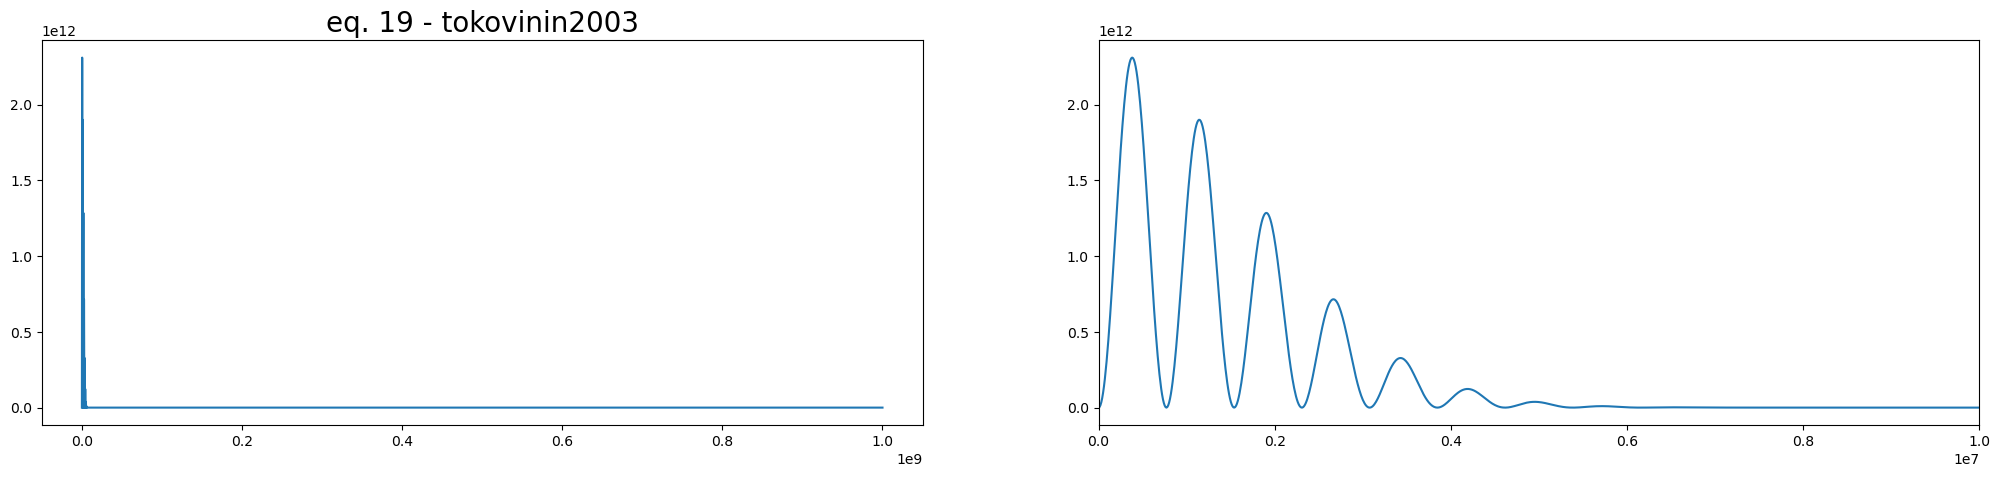

In [5]:
lambda_ = 650*pow(10, -9) # длина волны, [м]


max_lambda = 100000 # максимальное значение длины волны, [нм]
k = 100000

lambdas = np.linspace(0, max_lambda, k) * pow(10, -9) # длина волны, [м]
delta_lambdas = (max_lambda / len(lambdas)) * pow(10, -9) # период дискредизации, [м]
omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]

a1 = 1 / lambda_
a2 = np.sin(2 * np.pi * lambda_ * np.linspace(0, omega_lambdas_scale, k))
a3 = np.exp(-2 * pow(np.pi, 2) * pow(sigma, 2) * pow(np.linspace(0, omega_lambdas_scale, k), 2))
f = pow(a1 * a2 * a3, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))

ax1.plot(np.linspace(0, omega_lambdas_scale, k), f)
ax1.set_title('eq. 19 - tokovinin2003', fontsize = 20)

ax2.plot(np.linspace(0, omega_lambdas_scale, k), f)
ax2.set_xlim(xmax = 0.1*pow(10, 8))
ax2.set_xlim(xmin = 0*pow(10,8))

Text(0.5, 1.0, 'eq. 20 - tokovinin2003')

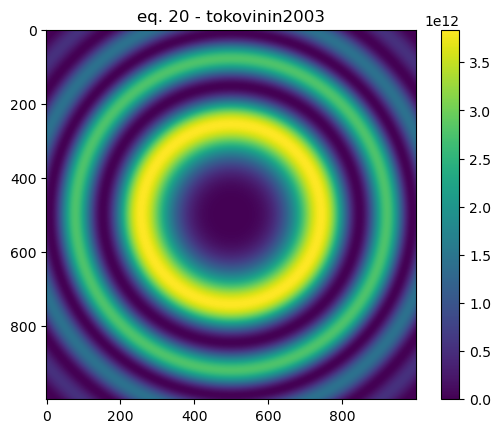

In [6]:
nx = 1000 # размер окна, [n_pix]
D = 2.5 # диаметр телескопа, [м]
D_pix = 228 # диаметр телескопа в пикселях, [n_pix]
lambda_ = 500*pow(10, -9) # длина волны, [м]
delta = D/D_pix # шаг субапертуры, период дискретизации (то, насколько одно значение отстает от следующего) [м]
z = 2000 # дистанция распространения, [м]
f_scale = 1/(delta*nx) # шаг по частоте, [м^-1]

xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
fx = f_scale * xx 
fy = f_scale * yy
f_abs = fx**2 + fy**2

sigma = 65 * pow(10, -9) # FWHM = 2*sqrt(2*Ln(2))*sigma, [м]
a1 = np.exp(- pow(np.pi, 2) * pow(z, 2) * pow(f_abs, 2) * pow(sigma, 2))
a2 = pow(np.sin(np.pi*z*lambda_*(f_abs)), 2)
a3 = pow(lambda_, -2)
S = a1 * a2 * a3 

plt.figure()
plt.imshow(S)
plt.colorbar()
plt.grid(False)
plt.title('eq. 20 - tokovinin2003')